In [56]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
import scipy.stats as stats

# modeling and evaluating
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score

import explore
import acquire

## Executive Summary:

### Project Goal: What features of randomly played music will induce emotions of vitality (labeled "energized"?

### Key Findings: A Random Forest Classifier performed the best across the train, validate and test data sets. (Roughly 75% for all three, beating baseline accuracy by 12%) I discovered through EDA and a simple Logistic Regression model that the most important features for inducing energized emotions while listening to randomly played tracks, are: liking the song, having a fast tempo (108-156 BPM) and being classical in genre. 
*****
*****
# Aquire and Prep Data
*****
*****

## Acquire data frame from two csv files

In [2]:
emotify_plus_df = acquire.new_data()

## Prepare and clean data prior to splitting into train, validate and test

In [3]:
df1 = acquire.prep_data(emotify_plus_df)

In [4]:
#sanity check
df1.head(1).T

,0
track_id,1
genre_x,classical
mood,3
age,21
gender,1
key,Dbm
minor_key,1
tempo,medium
liked,1
disliked,0


In [5]:
#sanity check
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8407 entries, 0 to 8406
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   track_id      8407 non-null   int64   
 1   genre_x       8407 non-null   object  
 2   mood          8407 non-null   int64   
 3   age           8407 non-null   int64   
 4   gender        8407 non-null   int64   
 5   key           8407 non-null   object  
 6   minor_key     8407 non-null   int64   
 7   tempo         8407 non-null   category
 8   liked         8407 non-null   int64   
 9   disliked      8407 non-null   int64   
 10  feel_sublime  8407 non-null   int64   
 11  agitated      8407 non-null   int64   
 12  energized     8407 non-null   int64   
 13  electronic    8407 non-null   uint8   
 14  pop           8407 non-null   uint8   
 15  rock          8407 non-null   uint8   
 16  medium        8407 non-null   uint8   
 17  fast          8407 non-null   uint8   
 18  very_fas

## Split data into train, validate and test
### Target for first iteration will be energized

In [6]:
target = 'energized'
df = df1
train, validate, test = explore.train_validate_test_split(df, target, seed=123)

In [7]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (4707, 19)
validate -> (2018, 19)
test -> (1682, 19)


In [8]:
#sanity check, visualize one row of train
train.head(1)

,track_id,genre_x,mood,age,gender,key,minor_key,tempo,liked,disliked,feel_sublime,agitated,energized,electronic,pop,rock,medium,fast,very_fast
3845,139,rock,4,62,0,Abm,1,fast,1,0,0,1,1,0,0,1,0,1,0


****
****
# Exploratory Data Analysis
****
****

### Visualize features and some prelimary investigating of feature relationships


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4707 entries, 3845 to 3653
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   track_id      4707 non-null   int64   
 1   genre_x       4707 non-null   object  
 2   mood          4707 non-null   int64   
 3   age           4707 non-null   int64   
 4   gender        4707 non-null   int64   
 5   key           4707 non-null   object  
 6   minor_key     4707 non-null   int64   
 7   tempo         4707 non-null   category
 8   liked         4707 non-null   int64   
 9   disliked      4707 non-null   int64   
 10  feel_sublime  4707 non-null   int64   
 11  agitated      4707 non-null   int64   
 12  energized     4707 non-null   int64   
 13  electronic    4707 non-null   uint8   
 14  pop           4707 non-null   uint8   
 15  rock          4707 non-null   uint8   
 16  medium        4707 non-null   uint8   
 17  fast          4707 non-null   uint8   
 18  very_

In [10]:
cat_vars = ['genre_x', 'mood', 'gender', 'key', 'minor_key', 'tempo', 'liked', 'disliked', 'feel_sublime', 'agitated']
quant_vars = ['track_id', 'age']
cat_var = ['genre_x', 'mood', 'gender', 'key', 'minor_key', 'tempo', 'liked', 'disliked', 'feel_sublime', 'agitated']
quant_var = ['track_id', 'age']

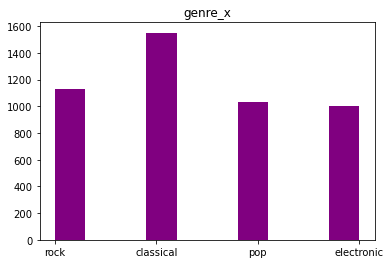

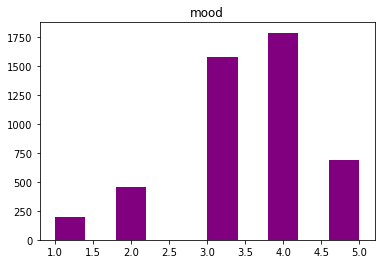

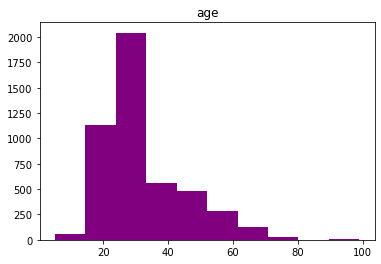

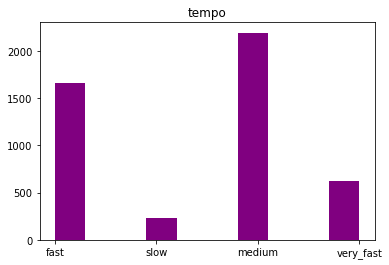

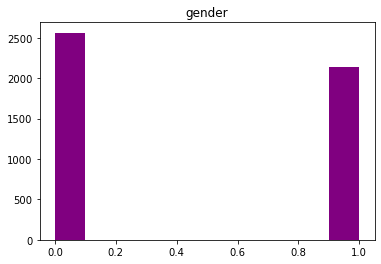

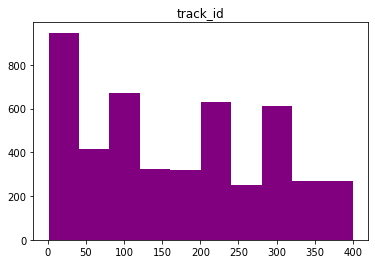

In [14]:
cols = ['genre_x', 'mood', 'age', 'tempo', 'gender', 'track_id']
for col in cols:
    plt.hist(train[col], color='purple')
    plt.title(col)
    plt.show()

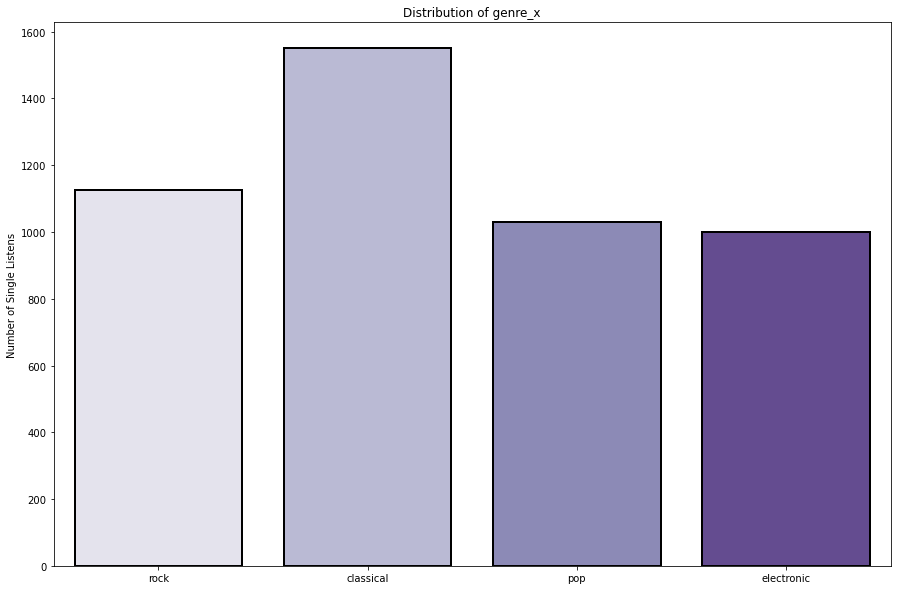

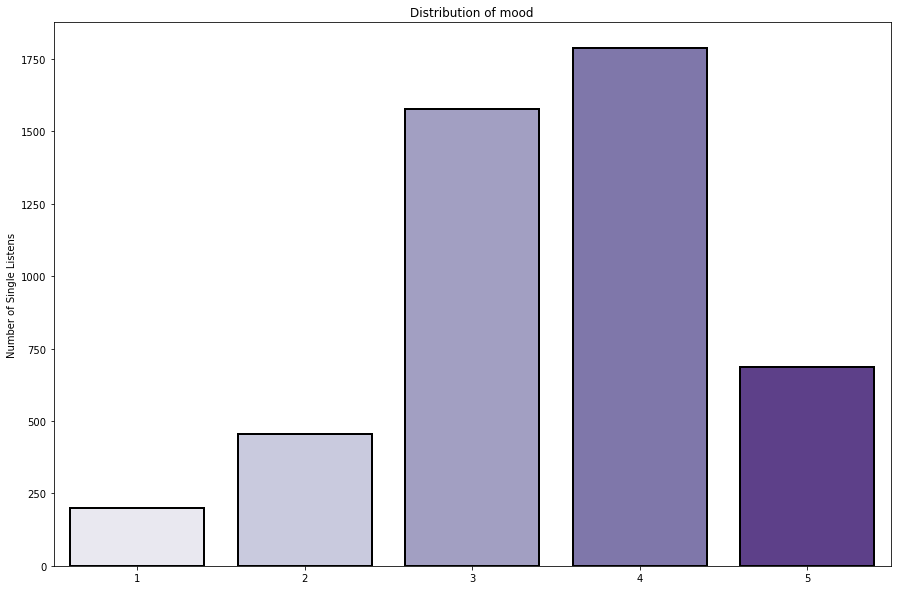

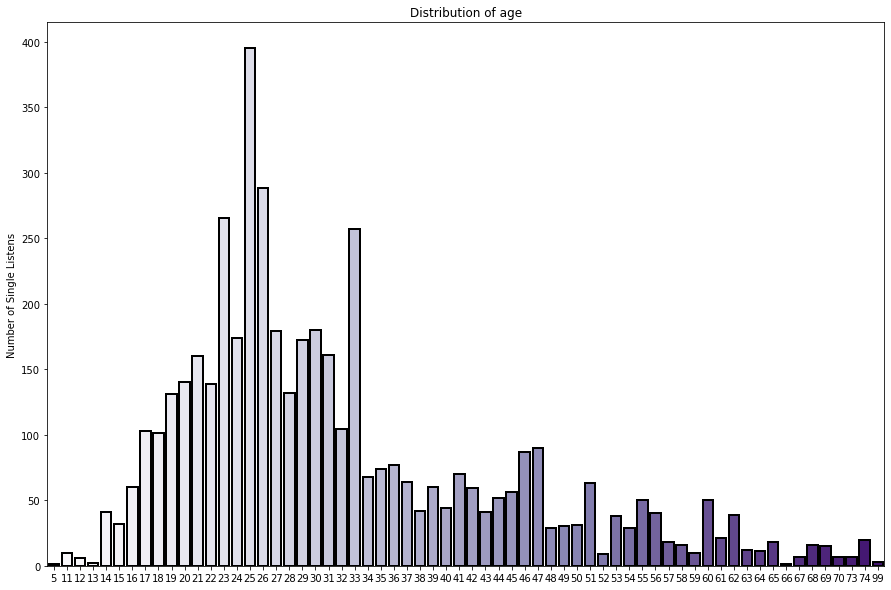

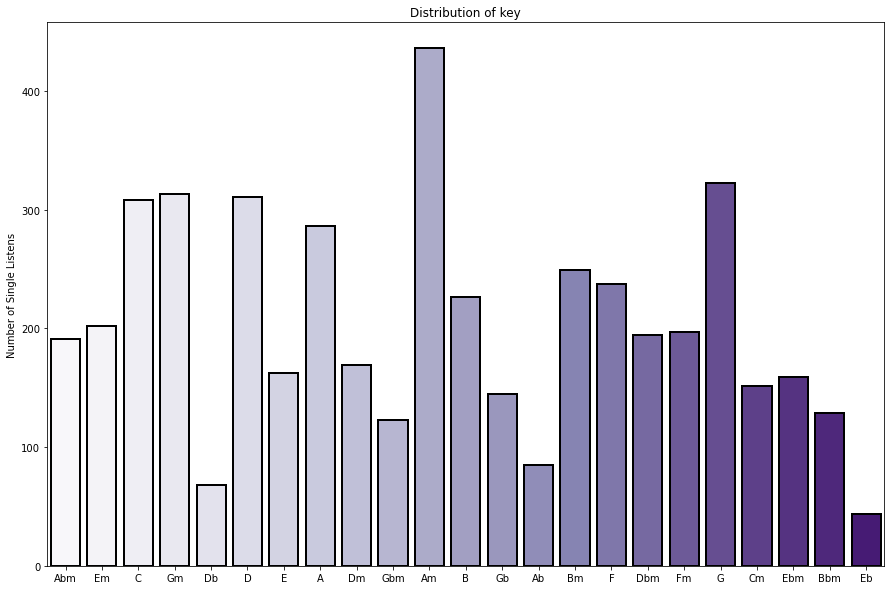

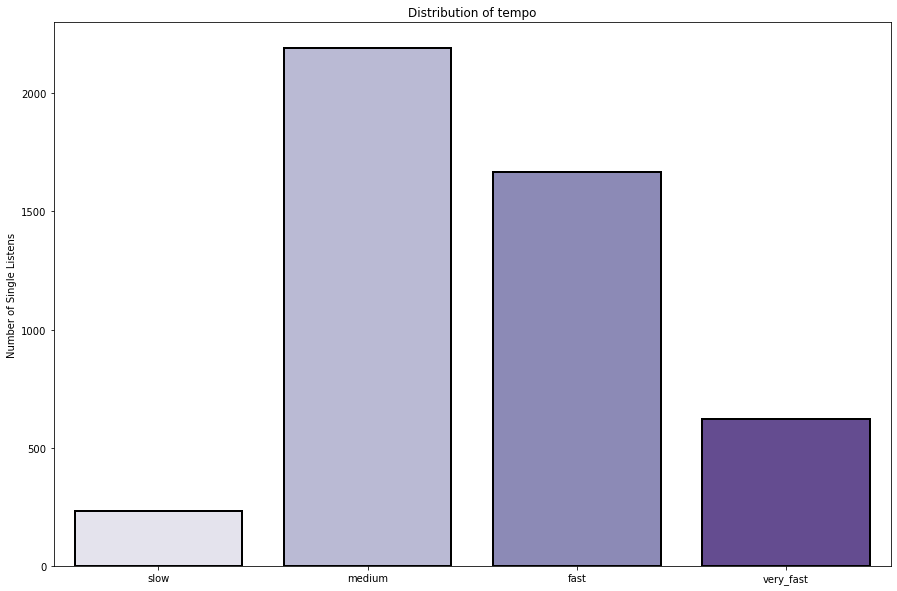

In [15]:

cols = ['genre_x', 'mood', 'age', 'key', 'tempo']

for col in cols:
    plt.figure(figsize=(15,10))
    sns.countplot(x = col, data=train, palette='Purples', ec='black', linewidth=2)

    plt.title('Distribution of ' + col)
    plt.xlabel('')
    plt.ylabel('Number of Single Listens')

    plt.show()

#### Key is a feature that is hard to interpret visually. Here is a horizontal bar graph to better visualize.

<AxesSubplot:>

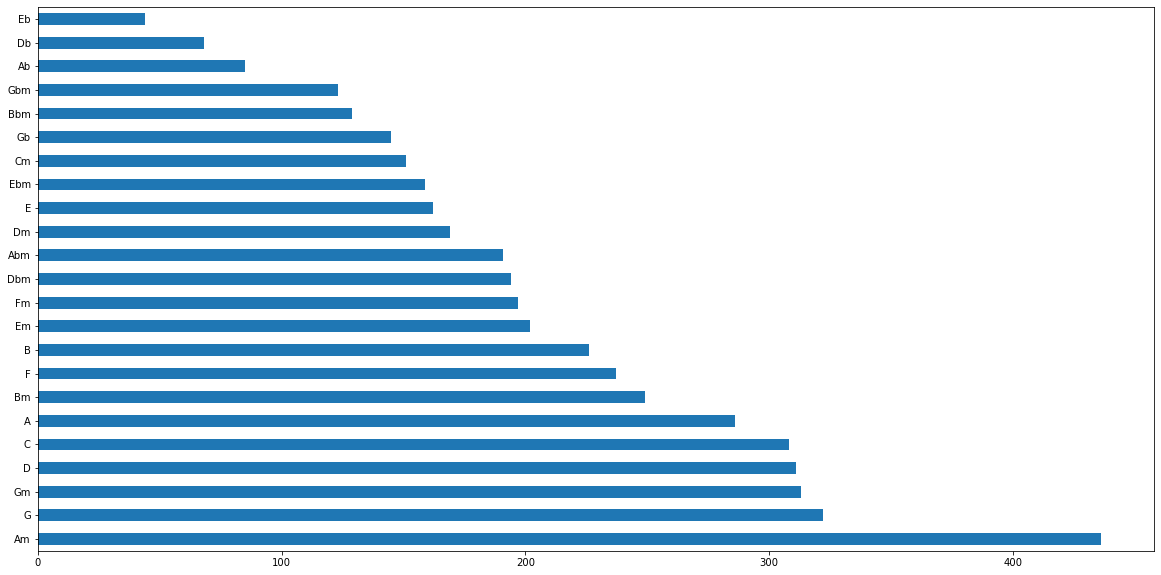

In [16]:
train['key'].value_counts().plot(kind='barh', figsize=(20,10))

### Takeaways from visualizing simple distributions:
    - Nothing is really that normal: genre_x, mood and age are somewhat normal in shape
    - The songs are largely unfamiliar, yet there are songs that were listened to more often than others.
        - Tracks 1-35, 75-110, 205-240, 280-320 look like they got more listens.
    - Gender is likely not a driving factor since they are about evenly distributed
    - Most songs are in the key of A minor
    - Most songs are a medium to fast tempo
    - Most listeners are in a okay(3) to good(4) mood.
    - Most listens were of classical music, although not by that much. 
    - The fewest listens were of electronic music.

In [18]:
train.describe()

,track_id,mood,age,gender,minor_key,liked,disliked,feel_sublime,agitated,energized,electronic,pop,rock,medium,fast,very_fast
count,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.00000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000,4707.000000
mean,169.165498,3.489696,32.019333,0.455492,0.533886,0.391120,0.205651,0.706607,0.36690,0.369025,0.212237,0.219035,0.239218,0.465477,0.353728,0.131719
std,117.142080,0.995768,12.507586,0.498068,0.498903,0.488053,0.404220,0.455365,0.48201,0.482592,0.408935,0.413637,0.426652,0.498860,0.478177,0.338221
min,1.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62.000000,3.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,160.000000,4.000000,28.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,275.000000,4.000000,38.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,400.000000,5.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


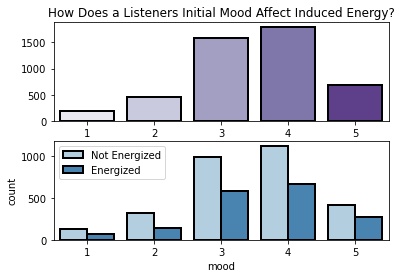

In [22]:
plt.subplot(211)

sns.countplot(x = 'mood', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does a Listeners Initial Mood Affect Induced Energy?')
plt.xlabel('')
plt.ylabel('')

plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'mood', hue = 'energized', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Not Energized', 'Energized'])

plt.show()

#### While there isn't a majority of songs that induce engergized emotions based on mood, it is interesting to see that regardless of mood, it appears that the chances of becoming energized while listening to music is about the same. (with the exception of very good mood and very bad mood where it's about half and half chance the listener will be energized)

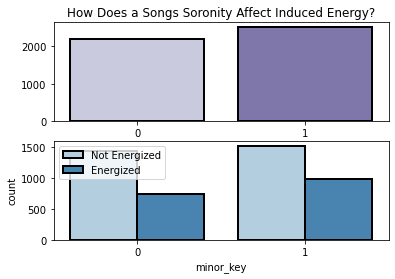

In [28]:
plt.subplot(211)

sns.countplot(x = 'minor_key', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does a Songs Soronity Affect Induced Energy?')
plt.xlabel('')
plt.ylabel('')


plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'minor_key', hue = 'energized', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Not Energized', 'Energized'])

plt.show()

#### The above charts seems to show that major and minor sonority have about the same affect of not energizing the listener.
#### This is a bit suprising considering that most people associate happiness with major sonority,and sadness with minor sonority.
#### I am pretty interested that it appears that nearly half of the songs in minor keys energized the listener.

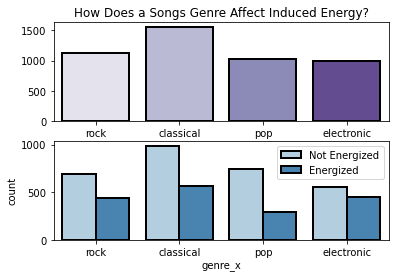

In [29]:
plt.subplot(211)

sns.countplot(x = 'genre_x', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does a Songs Genre Affect Induced Energy?')
plt.xlabel('')
plt.ylabel('')


plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'genre_x', hue = 'energized', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Not Energized', 'Energized'])

plt.show()

#### From this chart, it appears that genre, specifically pop, classical and rock have more chance of not engergizing the listener.

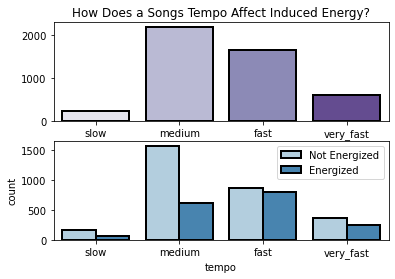

In [30]:
plt.subplot(211)

sns.countplot(x = 'tempo', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does a Songs Tempo Affect Induced Energy?')
plt.xlabel('')
plt.ylabel('')


plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'tempo', hue = 'energized', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Not Energized', 'Energized'])

plt.show()

#### This plot is curious to me. While no tempo group shows it caused more energized emotions, it does appear that medium and slow tempo songs cause the listener to more likely be not energized. Very fast tempos appear to have a bit of a majority not energized, and fast tempo seems to be causing about half and half. While this doesn't support my initial hunch that fast and very fast tempos will energize a listener, it does appear that tempo may have a strong relationship with induced emotions.

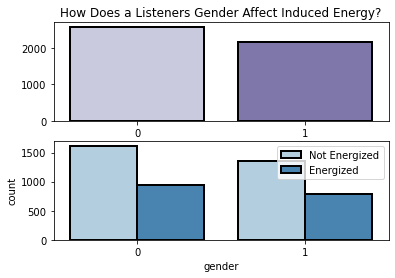

In [31]:
plt.subplot(211)

sns.countplot(x = 'gender', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('How Does a Listeners Gender Affect Induced Energy?')
plt.xlabel('')
plt.ylabel('')


plt.subplot(212)

# use hue to add another dimension to your viz
sns.countplot(x = 'gender', hue = 'energized', data=train, palette='Blues', ec='black', linewidth=2)

plt.legend(['Not Energized', 'Energized'])

plt.show()

#### There seems to be no difference in energized and not engergized.  I will consider this to be a lower factor in my target, and choose to explore other features.

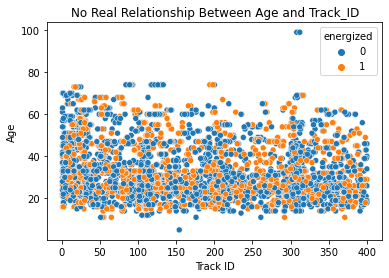

In [34]:
sns.scatterplot(x='track_id', y='age', data=train, hue='energized')
plt.title('No Real Relationship Between Age and Track_ID')
plt.xlabel('Track ID')
plt.ylabel('Age')

plt.show()

#### I notice there are some areas where the target is mixed, but you can see what look like bands of orange.
#### Around track 20-25 there seems to be a band of orange. (classical songs)
#### Around track 200-300: it appears there is more orange than blue (pop songs)
#### Around track 190-200 there is a lot of orange for listeners younger than 40. (pop songs)
#### Around track 250-290 there is a lot of orange for listeners over 30.(pop songs)
#### There are also clusters of blue indicating that there might be something going on with those tracks that are causing the listener to not feel energized.

<AxesSubplot:>

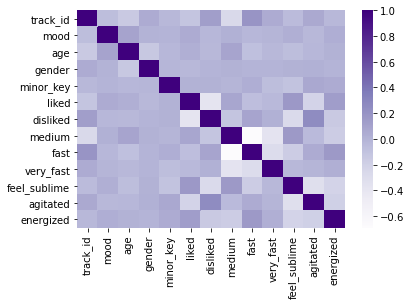

In [83]:
sns.heatmap(train[['track_id', 'mood', 'age', 'gender', 'minor_key', 'liked', 'disliked', 'tempo', 'medium', 'fast', 'very_fast', 'feel_sublime', 'agitated', 'energized']].corr(), cmap='Purples', annot=False)

#### It appears that fast, liked and mood are the top features here in the heatmap.
****

### After visualizing features, I will move forward with hypothesis testing:
####     Single features having an effect on the outcome(target: induced energy)
    All cat variables below
    Null hypothesis: Tempo has no effect on induced energy. A Hypothesis: Induced energy is dependent on tempo. (chi2)
    Null hypothesis: Major/Minor sonority has no effect on induced energy. A Hypothesis: Induced energy is dependent on major/minor sonority. (chi2)
    Null hypothesis: Current mood state has no effect on induced energy. A Hypothesis: Is induced energy different across moods? (chi2)
    Null hypothesis: Liking a song has no effect on induced energy. A Hypothesis: Is induced energy dependent on liking a song? ( chi2)
    Null hypothesis: Genre has no effect on induced energy. A hypothesis: Is induced energy related to genre? (chi2)
        
####     2 features together vs 2 features together:
    Two Cat var vs Two Cat:
    Null hypothesis: Fast classical pieces and fast rock pieces have the same effect on the outcome. (relationship: chi2 or comparison Ttest?)
    
    

####    Future iteration's hypotheses:     
    Null Hypothesis: Certain keys have no significant difference in emotional response.
    (ie Do certain keys yield more energized response than other keys?)
    One Num var One Cat var vs One Num Var and One Cat Var
    Null hypothesis: Older individuals listening to classical pieces and younger individuals listening to classical music have no difference of outcome. (comparison: ttest_ind, MannWhitneyU)
    Null hypothesis: Older individuals listening to fast pieces and younger individuals listening to fast music have no difference of outcome.    (comparison: ttest_ind, scipy.stats.MannWhitneyU)
    Null hypothesis: Older individuals listening to classical pieces have no difference of emotional outcome than the average listener to classical music. (comparison: ttest_1samp, MannWhitneyU
        
           
            
#### Since these are not life/death hypotheses, I am comfortable setting my confidence level at 95%.
#### My alpha is therefore, .05
#### Any p-value result lower than .05, we will reject the null hypothesis.

In [94]:
print(cat_vars)
print(quant_vars)

['genre_x', 'mood', 'gender', 'key', 'minor_key', 'tempo', 'liked', 'disliked', 'feel_sublime', 'agitated']
['track_id', 'age']


genre_x 
_____________________

        chi2       p-value  degrees of freedom
0  64.136624  7.674000e-14                   3

observed:
 energized      0     1   All
genre_x                     
classical    989   562  1551
electronic   551   448   999
pop          742   289  1031
rock         688   438  1126
All         2970  1737  4707

expected:
             0           1
0  978.642447  572.357553
1  630.344168  368.655832
2  650.535373  380.464627
3  710.478011  415.521989


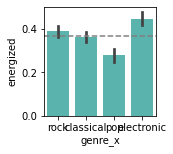


_____________________

mood 
_____________________

       chi2  p-value  degrees of freedom
0  8.917316   0.0632                   4

observed:
 energized     0     1   All
mood                       
1           128    73   201
2           314   141   455
3           989   587  1576
4          1123   665  1788
5           416   271   687
All        2970  1737  4707

expected:
              0           1
0   126.826004   74.173996
1   287.093690  167.906310
2   994.416826  581.583174
3  1128.183556  659.816444
4   433.479924  253.520076


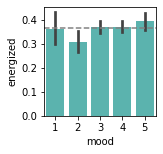


_____________________

gender 
_____________________

      chi2   p-value  degrees of freedom
0  0.00632  0.936636                   1

observed:
 energized     0     1   All
gender                     
0          1619   944  2563
1          1351   793  2144
All        2970  1737  4707

expected:
              0           1
0  1617.189293  945.810707
1  1352.810707  791.189293


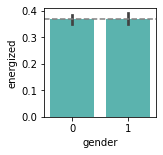


_____________________

key 
_____________________

         chi2       p-value  degrees of freedom
0  135.217173  2.795615e-18                  22

observed:
 energized     0     1   All
key                        
A           179   107   286
Ab           52    33    85
Abm         111    80   191
Am          261   175   436
B           109   117   226
Bbm         103    26   129
Bm          140   109   249
C           231    77   308
Cm          101    50   151
D           176   135   311
Db           64     4    68
Dbm         126    68   194
Dm          104    65   169
E           110    52   162
Eb           36     8    44
Ebm          92    67   159
Em          123    79   202
F           161    76   237
Fm          115    82   197
G           218   104   322
Gb          109    36   145
Gbm          76    47   123
Gm          173   140   313
All        2970  1737  4707

expected:
              0           1
0   180.458891  105.541109
1    53.632887   31.367113
2   120.516252   70

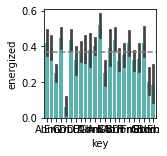


_____________________

minor_key 
_____________________

        chi2   p-value  degrees of freedom
0  13.261169  0.000271                   1

observed:
 energized     0     1   All
minor_key                  
0          1445   749  2194
1          1525   988  2513
All        2970  1737  4707

expected:
              0           1
0  1384.359465  809.640535
1  1585.640535  927.359465


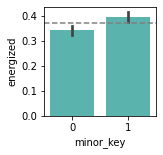


_____________________

tempo 
_____________________

         chi2       p-value  degrees of freedom
0  160.391494  1.508840e-34                   3

observed:
 energized     0     1   All
tempo                      
slow        161    70   231
medium     1569   622  2191
fast        869   796  1665
very_fast   371   249   620
All        2970  1737  4707

expected:
              0           1
0   145.755258   85.244742
1  1382.466539  808.533461
2  1050.573614  614.426386
3   391.204589  228.795411


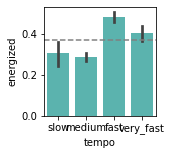


_____________________

liked 
_____________________

        chi2       p-value  degrees of freedom
0  89.833829  2.590271e-21                   1

observed:
 energized     0     1   All
liked                      
0          1962   904  2866
1          1008   833  1841
All        2970  1737  4707

expected:
              0            1
0  1808.374761  1057.625239
1  1161.625239   679.374761


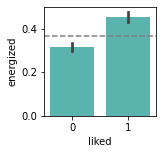


_____________________

disliked 
_____________________

        chi2       p-value  degrees of freedom
0  95.434062  1.529001e-22                   1

observed:
 energized     0     1   All
disliked                   
0          2228  1511  3739
1           742   226   968
All        2970  1737  4707

expected:
              0            1
0  2359.216061  1379.783939
1   610.783939   357.216061


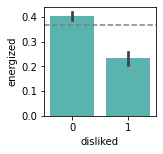


_____________________

feel_sublime 
_____________________

         chi2       p-value  degrees of freedom
0  226.537495  3.392201e-51                   1

observed:
 energized        0     1   All
feel_sublime                  
0              644   737  1381
1             2326  1000  3326
All           2970  1737  4707

expected:
              0            1
0   871.376673   509.623327
1  2098.623327  1227.376673


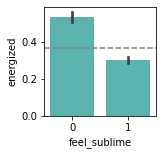


_____________________

agitated 
_____________________

         chi2       p-value  degrees of freedom
0  177.883295  1.404745e-40                   1

observed:
 energized     0     1   All
agitated                   
0          1667  1313  2980
1          1303   424  1727
All        2970  1737  4707

expected:
              0            1
0  1880.305927  1099.694073
1  1089.694073   637.305927


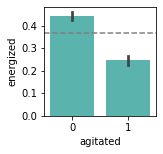


_____________________

track_id 
____________________



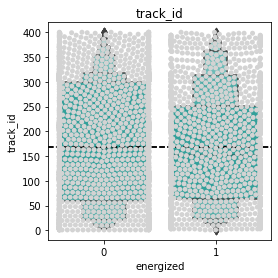

            count        mean         std  min   25%    50%     75%    max
energized                                                                 
0          2970.0  171.344781  119.329505  1.0  60.0  165.0  299.75  400.0
1          1737.0  165.439263  113.240898  1.0  64.0  152.0  251.00  400.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2639466.0, pvalue=0.18216165180861987)

____________________

age 
____________________



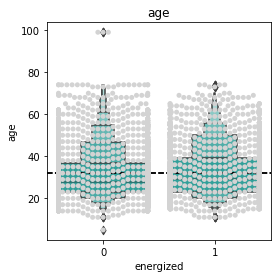

            count       mean        std   min   25%   50%   75%   max
energized                                                            
0          2970.0  31.882155  12.367979   5.0  23.0  28.0  37.0  99.0
1          1737.0  32.253886  12.742917  11.0  23.0  29.0  39.0  74.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2561064.0, pvalue=0.6826211216449565)

____________________



In [95]:
explore.explore_bivariate(train, 'energized', cat_vars, quant_vars)

tempo 
_____________________

         chi2       p-value  degrees of freedom
0  160.391494  1.508840e-34                   3

observed:
 energized     0     1   All
tempo                      
slow        161    70   231
medium     1569   622  2191
fast        869   796  1665
very_fast   371   249   620
All        2970  1737  4707

expected:
              0           1
0   145.755258   85.244742
1  1382.466539  808.533461
2  1050.573614  614.426386
3   391.204589  228.795411


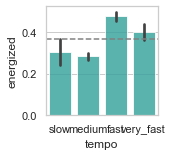


_____________________



In [114]:
explore.explore_bivariate_categorical(train, 'energized', 'tempo')

minor_key 
_____________________

        chi2   p-value  degrees of freedom
0  13.261169  0.000271                   1

observed:
 energized     0     1   All
minor_key                  
0          1445   749  2194
1          1525   988  2513
All        2970  1737  4707

expected:
              0           1
0  1384.359465  809.640535
1  1585.640535  927.359465


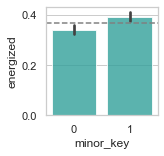


_____________________



In [115]:
explore.explore_bivariate_categorical(train, 'energized', 'minor_key')

#### Of the minor songs with a fast tempo, was genre the difference in who was energized and who wasnt?

genre_x 
_____________________

        chi2   p-value  degrees of freedom
0  18.432139  0.000358                   3

observed:
 energized     0    1  All
genre_x                  
classical    38   67  105
electronic  198  259  457
pop          70   48  118
rock        131  115  246
All         437  489  926

expected:
             0           1
0   49.551836   55.448164
1  215.668467  241.331533
2   55.686825   62.313175
3  116.092873  129.907127


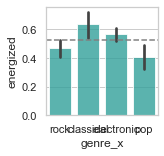


_____________________



In [110]:
minor_and_fast_subset = train[(train.minor_key==1) & (train.tempo==('fast'))]

explore.explore_bivariate_categorical(minor_and_fast_subset, 'energized', 'genre_x')

mood 
_____________________

       chi2  p-value  degrees of freedom
0  8.917316   0.0632                   4

observed:
 energized     0     1   All
mood                       
1           128    73   201
2           314   141   455
3           989   587  1576
4          1123   665  1788
5           416   271   687
All        2970  1737  4707

expected:
              0           1
0   126.826004   74.173996
1   287.093690  167.906310
2   994.416826  581.583174
3  1128.183556  659.816444
4   433.479924  253.520076


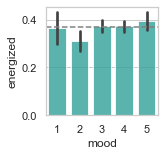


_____________________



In [116]:
explore.explore_bivariate_categorical(train, 'energized', 'mood')

liked 
_____________________

        chi2       p-value  degrees of freedom
0  89.833829  2.590271e-21                   1

observed:
 energized     0     1   All
liked                      
0          1962   904  2866
1          1008   833  1841
All        2970  1737  4707

expected:
              0            1
0  1808.374761  1057.625239
1  1161.625239   679.374761


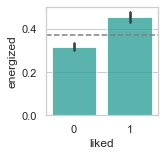


_____________________



In [117]:
explore.explore_bivariate_categorical(train, 'energized', 'liked')

## Takeaways:  
1. Tempo has an effect on inducing energy.
2. Minor/Major key has a effect on inducing energy.
3. It appears that fast tempo is the highest amount of energized.
4. There is a difference between genres of fast and minor key songs.
5. It appears that classical fast minor songs induce energy most often.
6. Mood does not have a significant effect of inducing energy.
7. Liking the song has an effect on inducing energy.

#### Given this information, 
#### I will perform a model using the features: fast, minor_key, classical, and liked.
#### Prior to performing that model, I will establish a baseline accuracy.
#### Then I will create a model using all features.
#### Lastly, I will create the model based on my EDA.  
#### It is my hope that the streamlined model will perform best.

*****
*****
# Modeling
*****
*****

In [58]:
train.energized.value_counts(normalize=True)

0    0.630975
1    0.369025
Name: energized, dtype: float64

## Baseline accuracy of 63% that listeners were not energized while listening to unfamiliar music.

In [51]:
train.columns

Index(['track_id', 'genre_x', 'mood', 'age', 'gender', 'key', 'minor_key',
       'tempo', 'liked', 'disliked', 'feel_sublime', 'agitated', 'energized',
       'electronic', 'pop', 'rock', 'medium', 'fast', 'very_fast'],
      dtype='object')

In [196]:
# I will drop any remaining categorical features I have left.

X_train = train.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_train = train[['energized']]

X_validate = validate.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_validate = validate[['energized']]

X_test = test.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_test = test[['energized']]

In [197]:
X_train.head(1)

,track_id,mood,age,gender,minor_key,liked,disliked,feel_sublime,agitated,electronic,pop,rock,medium,fast,very_fast
3845,139,4,62,0,1,1,0,0,1,0,0,1,0,1,0


In [198]:
# This is my target variable, my label.

y_train.head(1)

,energized
3845,1


In [199]:
# Create a simple Logistic Regression model to start.

logit = LogisticRegression(random_state=123)

In [200]:
logit.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [201]:
# Create a list of our model features.

features = X_train.columns.tolist()

In [202]:
# Create a list of the weights for each feature from our model.

weights = logit.coef_.flatten()

In [203]:
# Store our lists from above in a DataFrame.

pd.DataFrame(weights, features).reset_index().rename(columns={'index': 'feature', 0: 'weight'})

,feature,weight
0,track_id,0.000309
1,mood,0.106895
2,age,-0.001488
3,gender,0.112963
4,minor_key,0.182108
5,liked,0.477386
6,disliked,-0.982259
7,feel_sublime,-1.786987
8,agitated,-1.440066
9,electronic,0.081354


#### From the above list of feature importance, fast tempo and reporting liking the song are most influential in energized or not energized emotions were induced. 

In [204]:
# Create eval_df and rename the train survived column actual.
train_eval_df = train[['energized']].rename(columns={'energized': 'actual'})

# Add your baseline predictions.
train_eval_df['baseline'] = 0

# Predict whether a listener will be energized using the X_train data; add column to eval_df
train_eval_df['LR1_predicted'] = logit.predict(X_train)

# Estimate the probability of a listener being energized using the X_train data; add col to eval_df

train_eval_df['LR1_proba'] = logit.predict_proba(X_train)[:, 1]

train_eval_df.head()

,actual,baseline,LR1_predicted,LR1_proba
3845,1,0,1,0.673094
1152,1,0,1,0.527393
3639,0,0,0,0.170928
6911,0,0,0,0.175103
6219,0,0,0,0.330393


In [205]:
# Get our accuracy score for our logistic regression model.

logit.score(X_train, y_train)

0.7312513278096452

In [206]:
recall_score(train_eval_df.actual, train_eval_df.LR1_predicted, average=None)

array([0.88350168, 0.47092689])

In [207]:
precision_score(train_eval_df.actual, train_eval_df.LR1_predicted, average=None)

array([0.7406153 , 0.70274914])

In [208]:
pd.crosstab(index=train_eval_df.actual, 
            columns=train_eval_df.LR1_predicted, 
            rownames=['Actual'], 
            colnames=['Predicted'])

Predicted,0,1
Actual,,
0,2624,346
1,919,818


In [209]:
# My LR model is beating my baseline accuracy at predicting my target value, survived.

print(classification_report(y_true=train_eval_df.actual, y_pred=train_eval_df.LR1_predicted))

              precision    recall  f1-score   support

           0       0.74      0.88      0.81      2970
           1       0.70      0.47      0.56      1737

    accuracy                           0.73      4707
   macro avg       0.72      0.68      0.68      4707
weighted avg       0.73      0.73      0.72      4707



In [211]:
logit2 = LogisticRegression(C=.1, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs')

In [212]:
logit2.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight={0: 1, 1: 99}, random_state=123)

In [213]:
print('Coefficient: \n', logit2.coef_)
print('Intercept: \n', logit2.intercept_)

Coefficient: 
 [[ 0.00138407  0.05577938  0.00365723  0.20490176  0.11279454  0.43463109
  -0.80392995 -1.07612259 -0.92600491  0.13661017 -0.78078537 -0.21478759
   0.51778092  1.30793428  1.26767499]]
Intercept: 
 [3.66742921]


In [214]:
y_pred2 = logit2.predict(X_train)

In [215]:
y_pred_proba2 = logit2.predict_proba(X_train)

In [216]:
# make predictions

y_pred1 = logit.predict(X_validate)
y_pred2 = logit2.predict(X_validate)


print("Model 1: solver = lbfgs, c = 1")

# accuracy of model 1
print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

# confusion matrix of model 1
print(confusion_matrix(y_validate, y_pred1))

# classification report of model 1
print(classification_report(y_validate, y_pred1))

print("Model 2: solver = lbfgs, c = .1")

# accuracy of model 2
print('Accuracy: {:.2f}'.format(logit2.score(X_validate, y_validate)))

# confusion matrix of model 2
print(confusion_matrix(y_validate, y_pred2))

# classification report of model 2
print(classification_report(y_validate, y_pred2))

Model 1: solver = lbfgs, c = 1
Accuracy: 0.75
[[1141  132]
 [ 369  376]]
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1273
           1       0.74      0.50      0.60       745

    accuracy                           0.75      2018
   macro avg       0.75      0.70      0.71      2018
weighted avg       0.75      0.75      0.74      2018

Model 2: solver = lbfgs, c = .1
Accuracy: 0.37
[[   0 1273]
 [   0  745]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1273
           1       0.37      1.00      0.54       745

    accuracy                           0.37      2018
   macro avg       0.18      0.50      0.27      2018
weighted avg       0.14      0.37      0.20      2018



In [217]:
# make predictions

y_pred1 = logit.predict(X_validate)
y_pred2 = logit2.predict(X_validate)


print("Model 1: solver = lbfgs, c = 1")

# accuracy of model 1
print('Accuracy: {:.2f}'.format(logit.score(X_validate, y_validate)))

# confusion matrix of model 1
print(confusion_matrix(y_validate, y_pred1))

# classification report of model 1
print(classification_report(y_validate, y_pred1))

print("Model 2: solver = lbfgs, c = .1")

# accuracy of model 2
print('Accuracy: {:.2f}'.format(logit2.score(X_validate, y_validate)))

# confusion matrix of model 2
print(confusion_matrix(y_validate, y_pred2))

# classification report of model 2
print(classification_report(y_validate, y_pred2))

Model 1: solver = lbfgs, c = 1
Accuracy: 0.75
[[1141  132]
 [ 369  376]]
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1273
           1       0.74      0.50      0.60       745

    accuracy                           0.75      2018
   macro avg       0.75      0.70      0.71      2018
weighted avg       0.75      0.75      0.74      2018

Model 2: solver = lbfgs, c = .1
Accuracy: 0.37
[[   0 1273]
 [   0  745]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1273
           1       0.37      1.00      0.54       745

    accuracy                           0.37      2018
   macro avg       0.18      0.50      0.27      2018
weighted avg       0.14      0.37      0.20      2018



In [118]:
train.columns

Index(['track_id', 'genre_x', 'mood', 'age', 'gender', 'key', 'minor_key',
       'tempo', 'liked', 'disliked', 'feel_sublime', 'agitated', 'energized',
       'electronic', 'pop', 'rock', 'medium', 'fast', 'very_fast'],
      dtype='object')

In [133]:
# I will now use only the columns shown my EDA to use.

X_train = train[['minor_key', 'liked', 'fast']]
y_train = train[['energized']]

X_validate = train[['minor_key', 'liked', 'fast']]
y_validate = validate[['energized']]

X_test = train[['minor_key', 'liked', 'fast']]
y_test = test[['energized']]

In [134]:
X_train.head(1)

,minor_key,liked,fast
3845,1,1,1


In [135]:
# This is my target variable, my label.

y_train.head(1)

,energized
3845,1


In [136]:
# Create a simple Logistic Regression model to start.

logit = LogisticRegression(random_state=123)

In [137]:
logit.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [138]:
# Create a list of our model features.

features = X_train.columns.tolist()

In [139]:
# Create a list of the weights for each feature from our model.

weights = logit.coef_.flatten()

In [140]:
# Store our lists from above in a DataFrame.

pd.DataFrame(weights, features).reset_index().rename(columns={'index': 'feature', 0: 'weight'})

,feature,weight
0,minor_key,0.199406
1,liked,0.652240
2,fast,0.770481


In [141]:
# Create eval_df and rename the train survived column actual.
train_eval_df = train[['energized']].rename(columns={'energized': 'actual'})

# Add your baseline predictions.
train_eval_df['baseline'] = 0

# Predict whether a listener will be energized using the X_train data; add column to eval_df
train_eval_df['LR1_predicted'] = logit.predict(X_train)

# Estimate the probability of a listener being energized using the X_train data; add col to eval_df

train_eval_df['LR1_proba'] = logit.predict_proba(X_train)[:, 1]

train_eval_df.head()

,actual,baseline,LR1_predicted,LR1_proba
3845,1,0,1,0.604420
1152,1,0,0,0.443166
3639,0,0,0,0.269177
6911,0,0,0,0.231794
6219,0,0,0,0.269177


In [142]:
# Get our accuracy score for our logistic regression model.

logit.score(X_train, y_train)

0.6543445931591247

In [143]:
recall_score(train_eval_df.actual, train_eval_df.LR1_predicted, average=None)

array([0.92121212, 0.1980426 ])

In [144]:
precision_score(train_eval_df.actual, train_eval_df.LR1_predicted, average=None)

array([0.66263018, 0.59515571])

In [145]:
pd.crosstab(index=train_eval_df.actual, 
            columns=train_eval_df.LR1_predicted, 
            rownames=['Actual'], 
            colnames=['Predicted'])

Predicted,0,1
Actual,,
0,2736,234
1,1393,344


In [146]:
# My LR model is beating my baseline accuracy at predicting my target value, survived.

print(classification_report(y_true=train_eval_df.actual, y_pred=train_eval_df.LR1_predicted))

              precision    recall  f1-score   support

           0       0.66      0.92      0.77      2970
           1       0.60      0.20      0.30      1737

    accuracy                           0.65      4707
   macro avg       0.63      0.56      0.53      4707
weighted avg       0.64      0.65      0.60      4707



### Feeding the model the features with highest importance did not make the model perform better.
### What if I do a different type of model?

In [148]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [187]:
X_train = train.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_train = train.energized

X_validate = validate.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_validate = validate.energized

X_test = test.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_test = test.energized

In [188]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=6, 
                            random_state=123)


In [189]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=3, random_state=123)

In [190]:
print(rf.feature_importances_)
print(X_train.columns)

[0.09907346 0.0237517  0.04966173 0.00717637 0.02218393 0.07296276
 0.07104708 0.27710084 0.19278628 0.0176066  0.01756637 0.007344
 0.06966647 0.06014896 0.01192344]
Index(['track_id', 'mood', 'age', 'gender', 'minor_key', 'liked', 'disliked',
       'feel_sublime', 'agitated', 'electronic', 'pop', 'rock', 'medium',
       'fast', 'very_fast'],
      dtype='object')


In [191]:
y_pred = rf.predict(X_train)

In [192]:
y_pred_proba = rf.predict_proba(X_train)

In [193]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.75


In [194]:
print(confusion_matrix(y_train, y_pred))

[[2850  120]
 [1035  702]]


In [195]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on test set: 0.75


In [178]:
from sklearn.neighbors import KNeighborsClassifier

In [179]:
X_train = train.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_train = train.energized

X_validate = validate.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_validate = validate.energized

X_test = test.drop(columns=['genre_x', 'key', 'tempo', 'energized'])
y_test = test.energized

In [180]:
# weights = ['uniform', 'density']
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

In [181]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [182]:
y_pred = knn.predict(X_train)

In [183]:
y_pred_proba = knn.predict_proba(X_train)

In [184]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.76


In [185]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      2970
           1       0.70      0.60      0.65      1737

    accuracy                           0.76      4707
   macro avg       0.74      0.72      0.73      4707
weighted avg       0.75      0.76      0.75      4707



In [218]:
print('Accuracy of KNN classifier on unseen validate set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on unseen validate set: 0.64


### Overall, the best performing model was the Random Forest Classifier. It performed with similar accuracy through train, validate and test data.
### This is not surpising considering the other best model was the logistic regression model using all features.
### Even though, we found that there are features that do hold higher importance to others, it is clear there is still a blindspot in what combination of features actually will yield the greatest accuracy.
### With more time, I'd like to explore more combinations of features.